## Логистическая регрессия

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

In [171]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
     
    def __init__(self, C=1, alpha=0.01, max_epoch=10, penalty=''):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.penalty = penalty
        
    #Логистическая функция
    def F (self, z):        
        return 1/(1 + np.exp(-z))
          
    #Вычисление эмперического риска для всей выборки    
    # X - матрица наблюдений размерности (m, n+1). [[1, x_01, ..., x_0n], ..., [1, x_m1, ..., x_mn]] 
    # y - вектор меток классов размерности (m,)
    # w - коэффициенты разделяющей поверхности (В лекции theta). Строка размерности (n+1,): [w0, w1, ..., wn]
    def log_loss (self, X, y, w):
        eps = 1e-14
        fi = self.F(X.dot(w))
        fi = np.clip(fi, eps, 1-eps)
        Q = -(1/X.shape[0])*np.sum(y*np.log(fi) + (1 - y)*np.log(1 - fi))
        if self.penalty == 'l2': Q += np.sum(self.C*(w[1:]**2))
        if self.penalty == 'l1': Q += np.sum(self.C*np.abs(w[1:]))
        return Q
        
    #Вычисление градиента эмпирическго риска для одного наблюдения
    # xi - наблюдение. Вектор размерности (n+1,) с единицей в нулевой позиции: [1, xi1, ..., xin]  
    # yi - класс, к которому относится наблюдение x - 0 или 1. 
    # w - коэффициенты разделяющей поверхности (В лекции theta). Строка размерности (n+1,): [w0, w1, ..., wn]
    def grad_log_loss (self, xi, yi, w):
        grad = (self.F(xi.dot(w)) - yi)*xi
        if self.penalty == 'l2': grad[1:] += 2*self.C*w[1:]
        if self.penalty == 'l1': grad[1:] += self.C*np.sign(w[1:])
        return grad
        
   
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''        
        X_with_one = np.c_[np.ones(X.shape[0]),X]  # Добавляем к Х столбец c 1
        self.w = np.random.randn(X_with_one.shape[1]) # Инициализация вектора коэффициентов w
        m = X_with_one.shape[0] # Кол-во элементов в выборке
        error_epoch_list = list() # Список для хранения ошибок по эпохам
        error_iter_list = list() # Список для хранения ошибок по итерациям
        w_list = list([self.w]) # Список для хранения векторов коэффициентов w
        for epoch in range(self.max_epoch): # Цикл по всем эпохам
            indices = np.random.permutation(m) # Мешаем индексы выборки
            for idx in indices: # Проходимся по всем перемешанным индексам
                xi = X_with_one[idx] # Берем наблюдение с индексом idx ...
                yi = y[idx] # ... и его класс
                # Вычисляем градиент эмпирического риска на наблюдении с индексом idx
                gradient = self.grad_log_loss(xi, yi, self.w) 
                self.w = self.w - self.alpha * gradient # Изменяем коэффициенты w
                
                # Добавляем в соответствующий массив ошибку после итерации           
                error_iter_list.append(self.log_loss(X_with_one, y, self.w)) 
                
            # Добавляем в соответствующий массив ошибку после эпохи                         
            error_epoch_list.append(self.log_loss(X_with_one, y, self.w)) 
            w_list.append(self.w) # Добавляем в соответствующий массив коэффициенты w                                
        return self.w, w_list, error_epoch_list, error_iter_list    
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''    
        return self        
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat_proba = self.predict_proba(X)
        if y_hat_proba[0]>y_hat_proba[1]: y_hat = 1
        else: y_hat = 0            
        return y_hat
    
    
    def predict_proba(self, x):
        '''
        Возвращение вероятности каждого из классов
        '''
        p_plus = self.F(np.hstack([np.ones(1),x]).dot(w))
        y_hat_proba = (p_plus, 1-p_plus)        
        return y_hat_proba

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

In [189]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

In [190]:
model = MySGDClassifier(alpha=0.01, max_epoch=300)
w, w_list, error_epoch_list, error_iter_list = model.fit(X, y)
print('Без регуляризации:')
print('Веса: {}. Минимальная ошибка: {}'.format(w, error_epoch_list[len(error_epoch_list)-1]))

Без регуляризации:
Веса: [-7.86931356  1.63250263 -1.88824602]. Минимальная ошибка: 0.2725457328530605


In [196]:
modelL2 = MySGDClassifier(C=.01, alpha=0.01, max_epoch=300, penalty='l2')
w_L2, w_list_L2, error_epoch_list_L2, error_iter_list_L2 = model.fit(X, y)
print('С регуляризацией L2:')
print('Веса: {}. Минимальная ошибка: {}'.format(w_L2, error_epoch_list_L2[len(error_epoch_list_L2)-1]))

С регуляризацией L2:
Веса: [-7.87061854  1.64422485 -1.89145124]. Минимальная ошибка: 0.27281582234424545


In [197]:
modelL1 = MySGDClassifier(C=.01, alpha=0.01, max_epoch=300, penalty='l1')
w_L1, w_list_L1, error_epoch_list_L1, error_iter_list_L1 = model.fit(X, y)
print('С регуляризацией L1:')
print('Веса: {}. Минимальная ошибка: {}'.format(w_L1, error_epoch_list_L1[len(error_epoch_list_L1)-1]))

С регуляризацией L1:
Веса: [-7.85639801  1.64840698 -1.90936859]. Минимальная ошибка: 0.2732479829572849


In [198]:
def get_line(w, x):
    return w[0]/w[1] - w[2]*x/w[1]

In [199]:
def draw_graph(X, w, w_list, error_epoch_list, error_iter_list, title):
    plt.figure(figsize=(25,10))
    plt.subplot(131)
    plt.scatter(X[:,0], X[:,1], c=y)
    x_line = np.array([-2, 8])
    for w1 in w_list:
        plt.plot(x_line, get_line(w1, x_line), 'r--')
    plt.plot(x_line, get_line(w, x_line),'g-', linewidth=2.0)
    plt.title(title)
    plt.xlabel("$x_1$", fontsize=14)                     
    plt.ylabel("$x_2$", rotation=0, fontsize=14) 
    plt.subplot(132)
    plt.title('Error by epochs')
    plt.xlabel("Epochs", fontsize=14)                     
    plt.ylabel("$Q$", rotation=0, fontsize=14) 
    plt.plot(np.linspace(1, len(error_epoch_list), len(error_epoch_list)), error_epoch_list)
    plt.subplot(133)
    plt.title('Error by iterations')
    plt.xlabel("Iterations", fontsize=14)                     
    plt.ylabel("$Q$", rotation=0, fontsize=14)     
    plt.plot(np.linspace(1, len(error_iter_list)*X.shape[0], len(error_iter_list)), error_iter_list)
    plt.show()

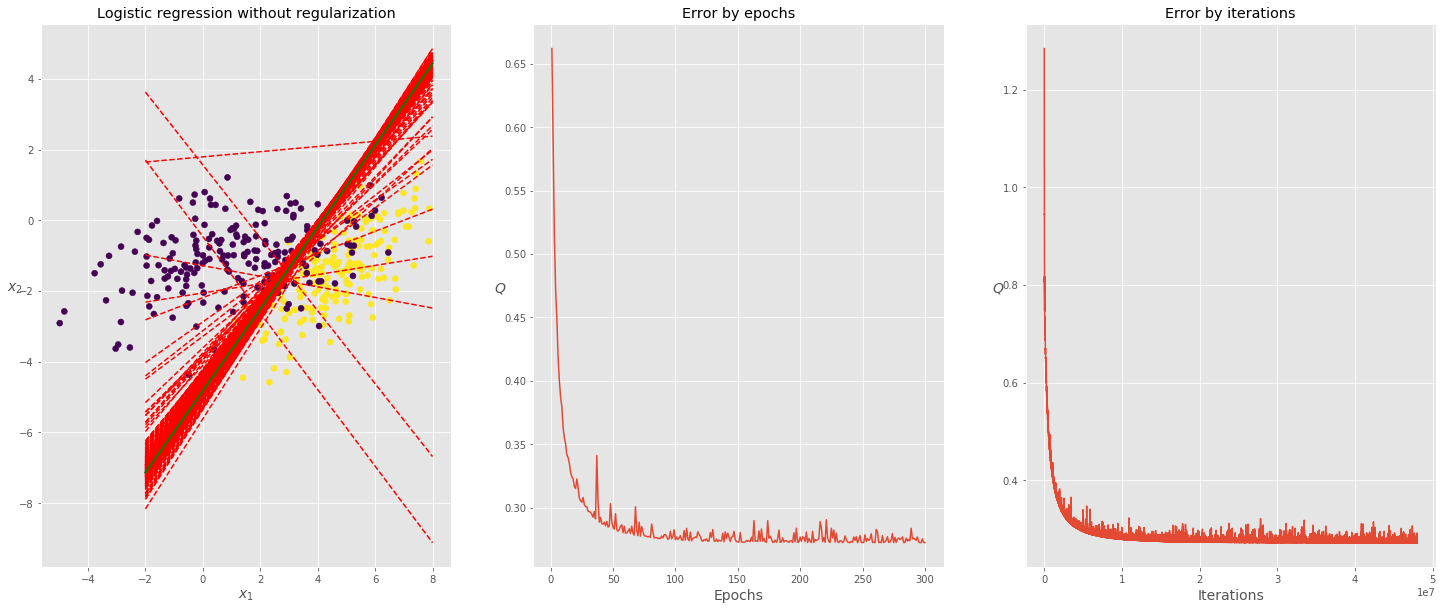

In [200]:
draw_graph(X, w, w_list, error_epoch_list, error_iter_list, 'Logistic regression without regularization')

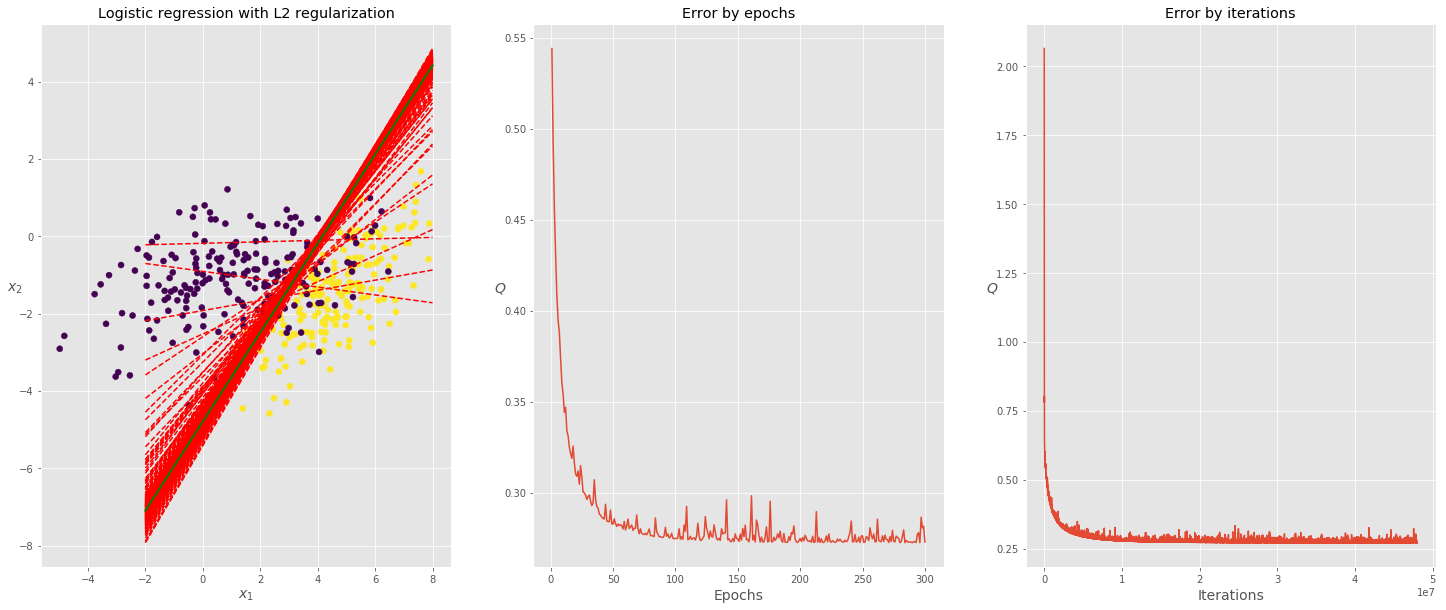

In [201]:
draw_graph(X, w_L2, w_list_L2, error_epoch_list_L2, error_iter_list_L2, 'Logistic regression with L2 regularization')

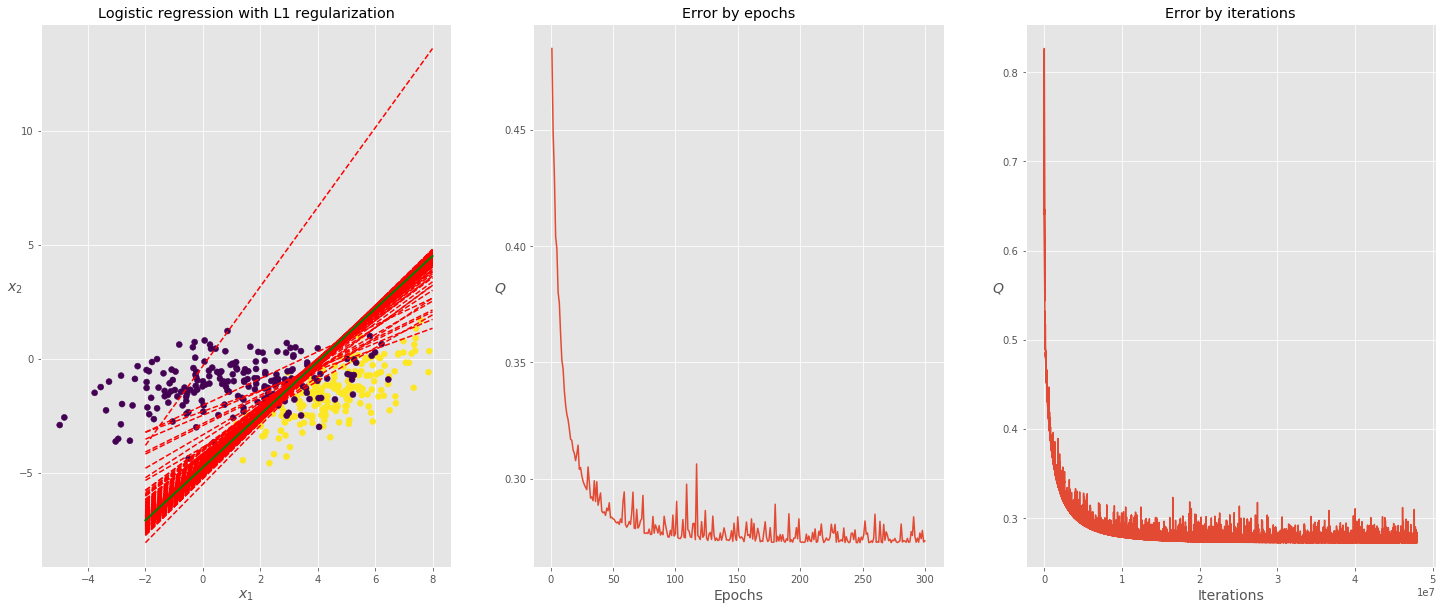

In [202]:
draw_graph(X, w_L1, w_list_L1, error_epoch_list_L1, error_iter_list_L1, 'Logistic regression with L1 regularization')

In [203]:
test = np.array([2 , -2])
print ('Логистическая регрессия без регуляризации')
print ('Вероятность классов: {}'.format(model.predict_proba(test)))
print ('Класс: {}'.format(model.predict(test)))
print ('Логистическая регрессия с L2 регуляризацией')
print ('Вероятность классов: {}'.format(modelL2.predict_proba(test)))
print ('Класс: {}'.format(modelL2.predict(test)))
print ('Логистическая регрессия с L1 регуляризацией')
print ('Вероятность классов: {}'.format(modelL1.predict_proba(test)))
print ('Класс: {}'.format(modelL1.predict(test)))

Логистическая регрессия без регуляризации
Вероятность классов: (0.30410700713566474, 0.69589299286433526)
Класс: 0
Логистическая регрессия с L2 регуляризацией
Вероятность классов: (0.30410700713566474, 0.69589299286433526)
Класс: 0
Логистическая регрессия с L1 регуляризацией
Вероятность классов: (0.30410700713566474, 0.69589299286433526)
Класс: 0


## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

In [204]:
range_alpha = np.linspace(0.5, 0.001, num=4)
max_epoch = 200
errors_nan = list()
errors_L1 = list()
errors_L2 = list()
for alpha in range_alpha:
    model = MySGDClassifier(alpha=alpha, max_epoch=max_epoch)
    w, w_list, error_epoch_list, error_iter_list = model.fit(X, y)
    errors_nan.append(error_epoch_list)
    modelL1 = MySGDClassifier(C=.01, alpha=alpha, max_epoch=max_epoch, penalty='l1')
    w, w_list, error_epoch_list, error_iter_list = model.fit(X, y)
    errors_L1.append(error_epoch_list)    
    modelL2 = MySGDClassifier(C=.01, alpha=alpha, max_epoch=max_epoch, penalty='l2')
    w, w_list, error_epoch_list, error_iter_list = model.fit(X, y)
    errors_L2.append(error_epoch_list)        

C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


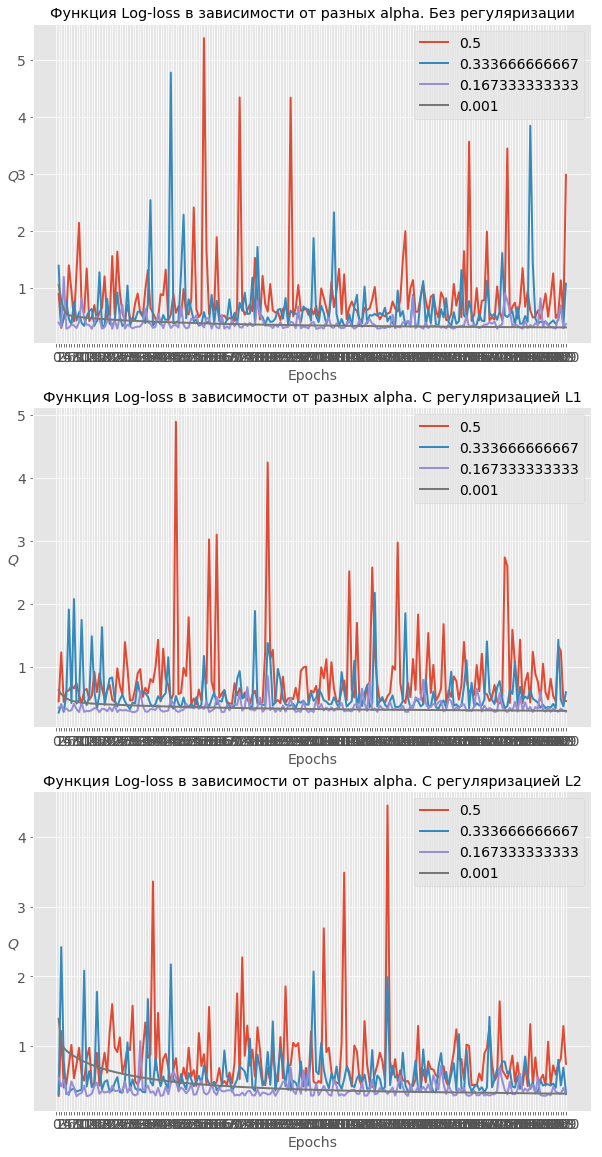

In [206]:
plt.figure(figsize=(10,20))
for i in range(0, len(errors_nan)):
    plt.subplot(311)
    plt.plot(np.linspace(1, max_epoch, num=max_epoch), errors_nan[i], linewidth=2)
    plt.legend(range_alpha, fontsize=14)
    plt.title('Функция Log-loss в зависимости от разных alpha. Без регуляризации')
    plt.xlabel("Epochs", fontsize=14)                     
    plt.ylabel("$Q$", rotation=0, fontsize=14)     
    plt.xticks(np.arange(max_epoch+1), fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplot(312)
    plt.plot(np.linspace(1, max_epoch, num=max_epoch), errors_L1[i], linewidth=2)
    plt.legend(range_alpha, fontsize=14)
    plt.title('Функция Log-loss в зависимости от разных alpha. С регуляризацией L1')
    plt.xlabel("Epochs", fontsize=14)                     
    plt.ylabel("$Q$", rotation=0, fontsize=14)     
    plt.xticks(np.arange(max_epoch+1), fontsize=14)
    plt.yticks(fontsize=14)
    plt.subplot(313)
    plt.plot(np.linspace(1, max_epoch, num=max_epoch), errors_L2[i], linewidth=2)
    plt.legend(range_alpha, fontsize=14)
    plt.title('Функция Log-loss в зависимости от разных alpha. С регуляризацией L2')
    plt.xlabel("Epochs", fontsize=14)                     
    plt.ylabel("$Q$", rotation=0, fontsize=14)     
    plt.xticks(np.arange(max_epoch+1), fontsize=14)
    plt.yticks(fontsize=14)    
plt.show()